<a href="https://colab.research.google.com/github/lucabem/CompeticionMineria/blob/main/batch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib

In [4]:
!rm -rf /root/.keras/datasets/*

In [5]:
dataset_url = 'https://github.com/lucabem/CompeticionMineria/blob/main/data/dataset_images.zip?raw=true'
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='train_data', 
                                   extract=True)

78069760/78067648 [==============================] - 2s 0us/step


In [6]:
!rm -rf /root/.keras/datasets/train_data.tar.gz /root/.keras/datasets/train_data
!ls -l /root/.keras/datasets/

total 24
drwxr-xr-x 27 root root  4096 Mar  9 01:09 ImagesTrain
drwxr-xr-x  2 root root 20480 Mar  9 01:09 Test


In [7]:
train_path = pathlib.Path('/root/.keras/datasets/ImagesTrain')
image_count = len(list(train_path.glob('*/*.jpg')))
print(image_count)

2500


In [8]:
test_path = pathlib.Path('/root/.keras/datasets/Test')
images_test = os.listdir(test_path)
print(len(images_test))

500


In [9]:
for direct in train_path.iterdir():
  if direct.is_dir():
    direct.rename(train_path / direct.name.split(sep='_100')[0])

In [10]:
batch_size = 32
img_height = 224
img_width  = 224

In [11]:
!pip install tensorflow-addons

     |████████████████████████████████| 706kB 5.1MB/s 


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
import tensorflow_addons as tfa

In [14]:
from keras.preprocessing.image import ImageDataGenerator  
from keras.applications import densenet  
from keras.models import Sequential, Model, load_model  
from keras.layers import Conv2D, MaxPooling2D  
from keras.layers import Activation, Dropout, Flatten, Dense  
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  
from keras import regularizers  
from keras import backend as K  
import tensorflow as tf
keras = tf.keras

### Data Augmentation

In [15]:
batch_size  = 32
img_height = 224
img_width  = 224
train_path = pathlib.Path('/root/.keras/datasets/ImagesTrain')

In [16]:
import shutil
import os 

In [17]:
train_ds_gen = ImageDataGenerator(vertical_flip    = True,
                                  horizontal_flip  = True,
                                  validation_split = 0.2)

In [18]:
train_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  subset='training',
                                                  class_mode='categorical')

Found 2000 images belonging to 25 classes.


In [19]:
valid_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  subset='validation',
                                                  class_mode='categorical')

Found 500 images belonging to 25 classes.


In [20]:
test_data_gen = train_ds_gen.flow_from_directory(batch_size=batch_size,
                                                  directory=train_path,
                                                  shuffle=True,
                                                  target_size=(img_height, img_width),
                                                  class_mode='categorical')

Found 2500 images belonging to 25 classes.


### Modelos

#### Funcion para predecir

In [21]:
batch_size = 68
img_height = 224
img_width  = 224
test_path  = pathlib.Path('/root/.keras/datasets/Test')

In [22]:
# predicting images
from keras.preprocessing import image
import numpy as np
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt

def make_predictions(model_final,
                     path_test ='/root/.keras/datasets/Test',
                     name_file_submission = 'submission.csv'):

  images_test = os.listdir(path_test)
  samples_to_predict = []

  for img in images_test:
    path_img = os.path.join(path_test, img)
    img = image.load_img(path_img,
                        target_size=(img_width, img_height))
    x = image.img_to_array(img)
    samples_to_predict.append(x)

  samples_to_predict  = np.array(samples_to_predict)
  predictions = model_final.predict(samples_to_predict)
  classes = np.argmax(predictions, axis = 1)

  data = {'id.jpg': images_test, 'label': classes}
  data = pd.DataFrame(data)
  data.to_csv(name_file_submission, index = False)

  return data

# Modificaciones

In [25]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False

dense_layer_2048 = Dense(2048, activation='relu')
dense_layer_512  = Dense(512,  activation='relu')
dense_layer_1024 = Dense(1024, activation='relu')

conv_1024 = Conv2D(1024, (3,3), activation='relu')
conv_512  = Conv2D(512, (3,3), activation='relu')

flattern  = Flatten()
batch_normal = BatchNormalization()
dropout   = Dropout(0.25)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')

model_22 = tf.keras.Sequential([
  base_model,
  conv_1024,
  conv_512,
  flattern,
  dense_layer_2048,
  dropout,
  dense_layer_512,
  dropout,
  dense_layer_1024,
  prediction_layer
])

In [26]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model_22.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[ 'accuracy', tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [27]:
tf.random.set_seed(2021)

model_history_22 = model_22.fit(  
    train_data_gen,
    epochs=50,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size)

Epoch 1/50
63/63 [==============================] - 508s 8s/step - loss: 2.9746 - accuracy: 0.1661 - f1_score: 0.1462 - val_loss: 1.5037 - val_accuracy: 0.6295 - val_f1_score: 0.5928
Epoch 2/50
63/63 [==============================] - 499s 8s/step - loss: 1.6180 - accuracy: 0.5325 - f1_score: 0.5221 - val_loss: 0.9249 - val_accuracy: 0.7321 - val_f1_score: 0.7271
Epoch 3/50
63/63 [==============================] - 497s 8s/step - loss: 1.0793 - accuracy: 0.6767 - f1_score: 0.6740 - val_loss: 0.9085 - val_accuracy: 0.7366 - val_f1_score: 0.7339
Epoch 4/50
63/63 [==============================] - 498s 8s/step - loss: 0.8001 - accuracy: 0.7627 - f1_score: 0.7626 - val_loss: 0.6996 - val_accuracy: 0.7991 - val_f1_score: 0.7967
Epoch 5/50
63/63 [==============================] - 496s 8s/step - loss: 0.7014 - accuracy: 0.7704 - f1_score: 0.7700 - val_loss: 0.5700 - val_accuracy: 0.8482 - val_f1_score: 0.8477
Epoch 6/50
63/63 [==============================] - 494s 8s/step - loss: 0.5703 - acc

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

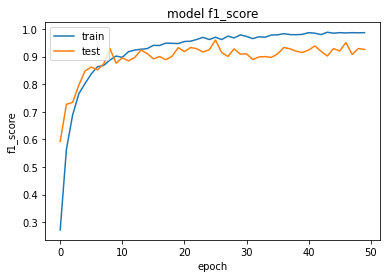

In [28]:
plt.plot(model_history_22.history['f1_score'])
plt.plot(model_history_22.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
make_predictions(model_22, name_file_submission='modelo_mejorado2_2048_512_1024_256_128_52.csv')

,id.jpg,label
0,Grassland__10.jpg,17
1,Open_Shrub_9.jpg,21
2,Forest_CEN_12.jpg,16
3,Forest_CEN_15.jpg,8
4,Forest_OEB_7.jpg,15
...,...,...
495,Forest_CDB_7.jpg,11
496,Open_Shrub_11.jpg,21
497,Close_Shru_0.jpg,2
498,Cropland_s_0.jpg,4


In [31]:
files.download("modelo_mejorado2_2048_512_1024_256_128_52.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:
model_22.save('modelo_mejorado2_2048_512_1024_256_128_52')

INFO:tensorflow:Assets written to: modelo_mejorado2_2048_512_1024_256_128_52/assets


In [35]:
! zip -r modelo_mejorado2_2048_512_1024_256_128_52.zip modelo_mejorado2_2048_512_1024_256_128_52

  adding: modelo_mejorado2_2048_512_1024_256_128_52/ (stored 0%)
  adding: modelo_mejorado2_2048_512_1024_256_128_52/assets/ (stored 0%)
  adding: modelo_mejorado2_2048_512_1024_256_128_52/variables/ (stored 0%)
  adding: modelo_mejorado2_2048_512_1024_256_128_52/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: modelo_mejorado2_2048_512_1024_256_128_52/variables/variables.index (deflated 78%)
  adding: modelo_mejorado2_2048_512_1024_256_128_52/saved_model.pb (deflated 93%)


In [36]:
files.download("modelo_mejorado2_2048_512_1024_256_128_52.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
batch_size2 = 100


In [38]:
base_model = tf.keras.applications.ResNet50(input_shape = (224, 224, 3), 
                                            classes     = 25,
                                            include_top  = False)

image_batch, label_batch = next(iter(train_data_gen))
feature_batch = base_model(image_batch)
base_model.trainable = False

dense_layer_2048 = Dense(2048, activation='relu')
dense_layer_1024 = Dense(1024, activation='relu')
dense_layer_512  = Dense(512,  activation='relu')

conv_1024 = Conv2D(1024, (3,3), activation='relu')
conv_512  = Conv2D(512, (3,3), activation='relu')

flattern  = Flatten()
batch_normal = BatchNormalization()
dropout   = Dropout(0.25)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = keras.layers.Dense(25, activation='softmax')

model_23 = tf.keras.Sequential([
  base_model,
  conv_1024,
  conv_512,
  flattern,
  dense_layer_2048,
  dropout,
  dense_layer_512,
  dropout,
  dense_layer_1024,
  prediction_layer
])

In [39]:
opt = tf.keras.optimizers.Adagrad()

callback = tf.keras.callbacks.EarlyStopping(monitor='f1_score', patience=5)

model_23.compile(loss="categorical_crossentropy",
              optimizer=opt,
	            metrics=[ 'accuracy', tfa.metrics.F1Score(num_classes=25, average='weighted')],
              )

In [ ]:
tf.random.set_seed(2021)

model_history_23 = model_23.fit(  
    train_data_gen,
    epochs=50,
    validation_data=valid_data_gen,
    validation_steps= valid_data_gen.n // batch_size2)

Epoch 1/50
63/63 [==============================] - 490s 8s/step - loss: 2.9718 - accuracy: 0.1775 - f1_score: 0.1691 - val_loss: 1.5061 - val_accuracy: 0.5813 - val_f1_score: 0.5418
Epoch 2/50
11/63 [====>.........................] - ETA: 6:17 - loss: 1.8758 - accuracy: 0.4378 - f1_score: 0.4197

In [ ]:
from google.colab import files
import matplotlib.pyplot as plt

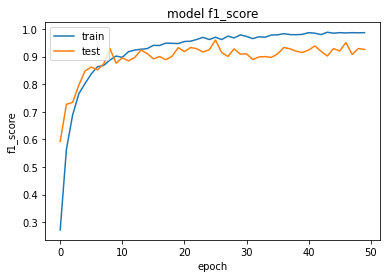

In [ ]:
plt.plot(model_history_23.history['f1_score'])
plt.plot(model_history_23.history['val_f1_score'])
plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
make_predictions(model_23, name_file_submission='modelo_mejorado3_2048_512_1024_256_128_52.csv')

,id.jpg,label
0,Grassland__10.jpg,17
1,Open_Shrub_9.jpg,21
2,Forest_CEN_12.jpg,16
3,Forest_CEN_15.jpg,8
4,Forest_OEB_7.jpg,15
...,...,...
495,Forest_CDB_7.jpg,11
496,Open_Shrub_11.jpg,21
497,Close_Shru_0.jpg,2
498,Cropland_s_0.jpg,4


In [ ]:
files.download("modelo_mejorado3_2048_512_1024_256_128_52.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model_22.save('modelo_mejorado3_2048_512_1024_256_128_52')

INFO:tensorflow:Assets written to: modelo_mejorado2_2048_512_1024_256_128_52/assets


In [ ]:
! zip -r modelo_mejorado3_2048_512_1024_256_128_52.zip modelo_mejorado3_2048_512_1024_256_128_52

  adding: modelo_mejorado2_2048_512_1024_256_128_52/ (stored 0%)
  adding: modelo_mejorado2_2048_512_1024_256_128_52/assets/ (stored 0%)
  adding: modelo_mejorado2_2048_512_1024_256_128_52/variables/ (stored 0%)
  adding: modelo_mejorado2_2048_512_1024_256_128_52/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: modelo_mejorado2_2048_512_1024_256_128_52/variables/variables.index (deflated 78%)
  adding: modelo_mejorado2_2048_512_1024_256_128_52/saved_model.pb (deflated 93%)


In [ ]:
files.download("modelo_mejorado3_2048_512_1024_256_128_52.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>